In [1]:
import os
import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error

import torch
import gpytorch

In [2]:
data_folder = 'Data_SNIa_LSST/'
df_data = pd.read_csv(data_folder+'hubble_diagram_Pr.txt', skiprows=4, sep=' ')
# dfs = pd.read_csv(data_folder+'hubble_diagram_Sr.txt', skiprows=4, sep=' ')
# Np = len(dfp.values)
# Ns= len(dfs.values)
df_data.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS
0,0.04131,0.04131,36.31666,0.00969,0.00674
1,0.06876,0.06876,37.44798,0.00541,0.00627
2,0.13121,0.13121,38.94492,0.01969,0.00868
3,0.18499,0.18499,39.75545,0.01338,0.00658
4,0.24503,0.24503,40.42469,0.01068,0.00590


In [3]:
df_data['errors'] = df_data['MUERR'].values+df_data['MUERR_SYS'].values
df_data.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS,errors
0,0.04131,0.04131,36.31666,0.00969,0.00674,0.01643
1,0.06876,0.06876,37.44798,0.00541,0.00627,0.01168
2,0.13121,0.13121,38.94492,0.01969,0.00868,0.02837
3,0.18499,0.18499,39.75545,0.01338,0.00658,0.01996
4,0.24503,0.24503,40.42469,0.01068,0.00590,0.01658


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


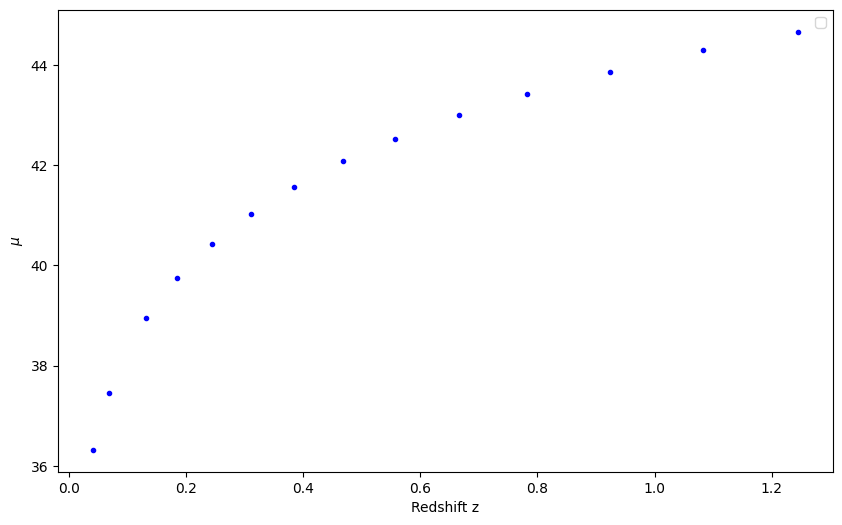

In [4]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(df_data['zCMB'].values, df_data['MU'].values, yerr=df_data['errors'].values, fmt='.', color='b', elinewidth=1, ecolor='red')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [5]:
df_data = df_data[['zCMB', 'MU', 'errors']]

In [6]:
len(df_data)

14

In [7]:
df_data.head()

,zCMB,MU,errors
0,0.04131,36.31666,0.01643
1,0.06876,37.44798,0.01168
2,0.13121,38.94492,0.02837
3,0.18499,39.75545,0.01996
4,0.24503,40.42469,0.01658


In [8]:
z = df_data[['zCMB']].values
y = df_data[['MU', 'errors']].values

randomize = np.random.permutation(len(z))
z = z[randomize]
y = y[randomize]
len(z), len(y)

(14, 14)

In [9]:
zmin, zmax = np.min(z), np.max(z)
zmin, zmax

(0.04131, 1.24447)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


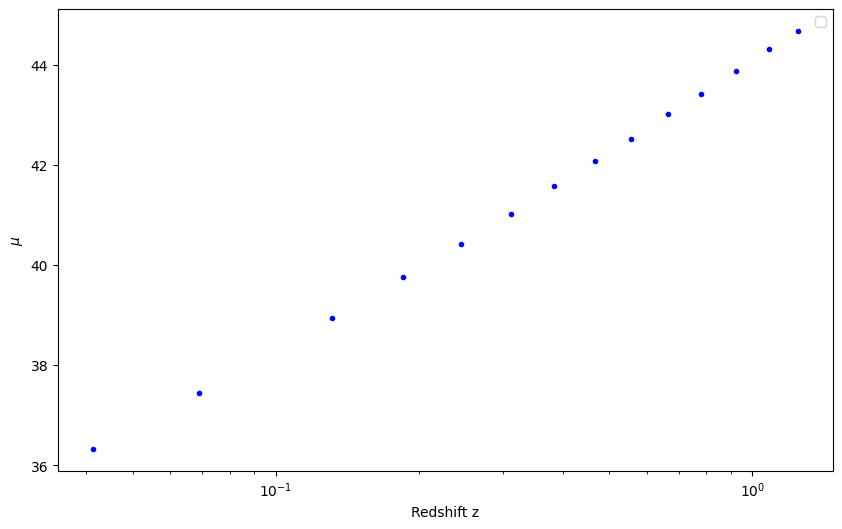

In [10]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(z, y[:, 0], yerr=y[:,1], fmt='.', color='b', elinewidth=1, ecolor='red')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.xscale('log')
plt.legend()

In [11]:
# split = 0.8
# ntrain = int(split * len(z))
# indx = [ntrain]
# z_train, z_test = np.split(z, indx)
# y_train, y_test = np.split(y, indx)

In [12]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 1.3, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [13]:
# yy = y[:,0].reshape(-1,1)
# zz = z
# split = 0.8
# ntrain = int(split * len(zz))
# indx = [ntrain]
# zz_train, zz_test = np.split(zz, indx)
# yy_train, yy_test = np.split(yy, indx)
# yy_train = np.append(yy_train, np.array([y[0], y[-1]]))
# zz_train = np.append(zz_train, np.array([z[0], z[-1]]))
np.shape(z), np.shape(y), np.shape(z), np.shape(y)

((14, 1), (14, 2), (14, 1), (14, 2))

In [14]:
# x_train = torch.tensor(z_train).reshape(len(z_train),)
# y_train = torch.tensor(y_train)

z_torch = torch.from_numpy(z).float()
y_torch = torch.from_numpy(y).float()

In [15]:
len(z)

14

In [16]:
np.shape(z), np.shape(y)

((14, 1), (14, 2))

In [17]:
# Definir el modelo de proceso gaussiano
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(z_torch, y_torch, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
#             gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
            gpytorch.kernels.MaternKernel(nu=1.5, lengthscale=2), num_tasks=2, rank=1
#             gpytorch.kernels.SpectralMixtureKernel(num_mixtures=2), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(z_torch, y_torch, likelihood)

In [18]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 100
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(z_torch)
    loss = -mll(output, y_torch)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

/home/isidro/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iter 1/100 - Loss: 20.674
Iter 2/100 - Loss: 18.909
Iter 3/100 - Loss: 17.268
Iter 4/100 - Loss: 15.764
Iter 5/100 - Loss: 14.406
Iter 6/100 - Loss: 13.197
Iter 7/100 - Loss: 12.134
Iter 8/100 - Loss: 11.205
Iter 9/100 - Loss: 10.387
Iter 10/100 - Loss: 9.655
Iter 11/100 - Loss: 8.997
Iter 12/100 - Loss: 8.407
Iter 13/100 - Loss: 7.881
Iter 14/100 - Loss: 7.416
Iter 15/100 - Loss: 7.008
Iter 16/100 - Loss: 6.649
Iter 17/100 - Loss: 6.330
Iter 18/100 - Loss: 6.042
Iter 19/100 - Loss: 5.780
Iter 20/100 - Loss: 5.539
Iter 21/100 - Loss: 5.319
Iter 22/100 - Loss: 5.118
Iter 23/100 - Loss: 4.938
Iter 24/100 - Loss: 4.776
Iter 25/100 - Loss: 4.630
Iter 26/100 - Loss: 4.494
Iter 27/100 - Loss: 4.367
Iter 28/100 - Loss: 4.246
Iter 29/100 - Loss: 4.132
Iter 30/100 - Loss: 4.026
Iter 31/100 - Loss: 3.929
Iter 32/100 - Loss: 3.840
Iter 33/100 - Loss: 3.756
Iter 34/100 - Loss: 3.674
Iter 35/100 - Loss: 3.594
Iter 36/100 - Loss: 3.518
Iter 37/100 - Loss: 3.447
Iter 38/100 - Loss: 3.380
Iter 39/100 

In [19]:
minrange = zmin
maxrange = zmax
x_test = torch.linspace(0, 1.3, 50)
np.shape(x_test)

torch.Size([50])

In [20]:
zmin, zmax

(0.04131, 1.24447)

In [21]:
x_test = x_test.reshape(len(x_test), )
# x_test = torch.from_numpy(x_test).float()
np.shape(x_test), type(x_test)

(torch.Size([50]), torch.Tensor)

In [22]:
model.eval()
likelihood.eval()

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [23]:
f_preds = model(x_test)

In [24]:
type(f_preds)

gpytorch.distributions.multitask_multivariate_normal.MultitaskMultivariateNormal

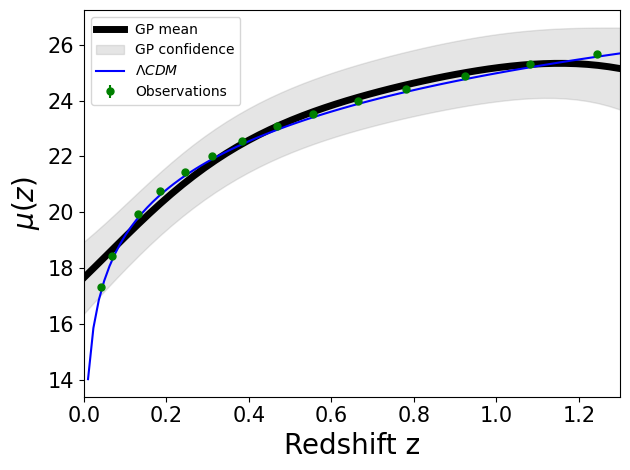

In [25]:
# # The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# # See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Obtain the predictive mean and covariance matrix
    f_preds = model(x_test)
    f_mean_mu = f_preds.mean[:, 0]
    f_mean_err = f_preds.mean[:, 1]
    f_cov = f_preds.covariance_matrix
    # Make predictions by feeding model through likelihood
    observed_pred = likelihood(model(x_test))
#     print(type(observed_pred))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    lower_mu = lower[:, 0]
    upper_mu = upper[:, 0]
    lower_err = lower[:, 0]
    upper_err = upper[:, 0]
    observed_pred_mean_mu = observed_pred.mean.numpy()[:, 0]
    observed_pred_mean_err = observed_pred.mean.numpy()[:, 1]
#     print(observed_pred.mean.numpy())
    plt.plot(x_test.numpy(), observed_pred_mean_mu-19, color='k', label='GP mean', linewidth=5)
#     # Shade between the lower and upper confidence bounds
    plt.fill_between(x_test.numpy(), lower_mu-19, upper_mu-19, alpha=0.2, label='GP confidence', color='gray')
#     plt.errorbar(x_test.numpy(), observed_pred_mean_mu-19, yerr=observed_pred_mean_err)

plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=10, label='Observations')


plt.xlim(0,1.3)

plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

In [26]:
np.shape(x_test.numpy()), np.shape(observed_pred_mean_mu), np.shape(observed_pred_mean_err)

((50,), (50,), (50,))